In [2]:
import pandas as pd
import datetime
import numpy as np
from tqdm import tqdm_notebook
from datetime import datetime,timedelta
import os
from timeit import default_timer as timer
from scipy import stats
os.chdir('/Users/hudsonyeo/Desktop/Python/leo/data/day/TA')
file_list=os.listdir('/Users/hudsonyeo/Desktop/Python/leo/data/day/TA')
file_list.sort()

In [2]:
file_list

['.DS_Store',
 '2019.01.02.csv',
 '2019.01.03.csv',
 '2019.01.04.csv',
 '2019.01.07.csv',
 '2019.01.08.csv',
 '2019.01.09.csv',
 '2019.01.10.csv',
 '2019.01.11.csv',
 '2019.01.14.csv',
 '2019.01.15.csv',
 '2019.01.16.csv',
 '2019.01.17.csv',
 '2019.01.18.csv',
 '2019.01.21.csv',
 '2019.01.22.csv',
 '2019.01.23.csv',
 '2019.01.24.csv',
 '2019.01.25.csv',
 '2019.01.28.csv',
 '2019.01.29.csv',
 '2019.01.30.csv',
 '2019.01.31.csv',
 '2019.02.01.csv',
 '2019.02.11.csv',
 '2019.02.12.csv',
 '2019.02.13.csv',
 '2019.02.14.csv',
 '2019.02.15.csv',
 '2019.02.18.csv',
 '2019.02.19.csv',
 '2019.02.20.csv',
 '2019.02.21.csv',
 '2019.02.22.csv',
 '2019.02.25.csv',
 '2019.02.26.csv',
 '2019.02.27.csv',
 '2019.02.28.csv',
 '2019.03.01.csv',
 '2019.03.04.csv',
 '2019.03.05.csv',
 '2019.03.06.csv',
 '2019.03.07.csv',
 '2019.03.08.csv',
 '2019.03.11.csv',
 '2019.03.12.csv',
 '2019.03.13.csv',
 '2019.03.14.csv',
 '2019.03.15.csv',
 '2019.03.18.csv',
 '2019.03.19.csv',
 '2019.03.20.csv',
 '2019.03.21.csv'

In [7]:
class categorise():
    def __init__(self):
        self.threshold=[]
        self.percentiles=[25,50,75]
        
    def fit(self,array):
        positive=array[array>0]
        negative=array[array<0]
        self.threshold.append(np.percentile(negative,self.percentiles))   
        self.threshold.append(np.percentile(positive,self.percentiles))
     
    def return_quartile(self,array):
        temp=[]
        for i in array:
            if i>=0:
                if i<self.threshold[1][0]:
                    temp.append(5)
                elif i<self.threshold[1][1]:
                    temp.append(6)
                elif i<self.threshold[1][2]:
                    temp.append(7)
                else:
                    temp.append(8)
            if i<0:
                if i>self.threshold[0][2]:
                    temp.append(4)
                elif i>self.threshold[0][1]:
                    temp.append(3)
                elif i>self.threshold[0][0]:
                    temp.append(2)
                else:
                    temp.append(1)
        return np.asarray(temp)
                

In [49]:
def calc_smart_price(dataset):
    data=dataset[:]
    
    #to combat the limit up event, where price is set to 0. 
    rows=(data.loc[:,'BidPrice1']==0) #count rows of bid price equal 0
    if (np.any(rows)): #if there is such a row
        data.at[rows,'BidPrice1']=data.loc[rows,'AskPrice1'] #for that row, assign ask price to it
    rows=(data.loc[:,'AskPrice1']==0) #do the same for ask price
    if (np.any(rows)):
        data.at[rows,'AskPrice1']=data.loc[rows,'BidPrice1'] 
        
    data['smart_price']=data.loc[:,'BidPrice1']*data.loc[:,'AskVol1']+data.loc[:,'AskPrice1']*data.loc[:,'BidVol1']
    data.at[:,'smart_price']=data.loc[:,'smart_price']/(data.loc[:,['BidVol1','AskVol1']].sum(axis=1))  
    return data

def calc_future_price(dataset,time_ahead=30):
    data=dataset[:]
    future_price=[]
    length=len(data)
    for i in range(len(data)):
        current_time=data[i,44]+timedelta(seconds=time_ahead)
        #print(data[i,44])
        j=0
        #print(current_time)
        while((i+j)<length and current_time>data[(i+j),44]):
            j+=1
        #print(i,j,(data[(i+j-1),44]))
        if (i+j)<length:
            future_price.append(data[(i+j),51]) #51 is the index for smart price            
        else:
            future_price.append(np.nan)
    future_price=np.asarray(future_price)
    future_price=np.expand_dims(future_price,axis=1)
    return np.concatenate((data,future_price),axis=1)


def calc_edge(dataset):
    data=dataset.copy()
    temp=data[:,52]-data[:,51]
    temp=np.expand_dims(temp,axis=1)
    return np.concatenate((data,temp),axis=1)

def set_index(dataset):
    data=dataset[:]
    index=data[:,44]
    new_index=[]
    for j in range(len(index)):
        i=str(index[j]*1000)
        if len(i)==11:
            i='0'+i
        i=i[:-10]+':'+i[-10:]
        i=i[:-8]+':'+i[-8:]
        i=i[:-6]+':'+i[-6:]
        new_index.append(datetime.strptime(i,"%H:%M:%S:%f"))
    data[:,44]=new_index
    return data
def calc_sma(dataset,duration=1): #not in use, just for reference
    #5 seconds for 5000 rows
    data=dataset[:]
    sma_values=[]

    for i in data[:,44]:
        last_time=i-timedelta(minutes=duration)
        sma=data[(data[:,44]>=last_time) & (data[:,44]<i)]
        if len(sma)!=0:
            sma=sma[:,51].mean()
        else:
            sma=np.nan
        sma_values.append(sma)
    sma_values=np.asarray(sma_values)
    sma_values=np.expand_dims(sma_values,axis=1)
    return np.concatenate((data,sma_values),axis=1)
def calc_sma_fast(dataset,duration=1): #faster way to calculate SMA, 0.05 seconds for 5000 rows
    data=dataset[:]
    sma_values=[] 
    smart_sum=np.cumsum(data[:,51])
    for i in range(len(data)):
        last_time=data[i,44]-timedelta(minutes=duration)
        j=220*duration#4x60=240
        while(i-j>0 and data[i-j,44]>last_time):
            j+=1
        if (i-j>=0):
            sma=(smart_sum[i]-smart_sum[i-j])/(j)
            sma_values.append(sma)
        else:
            sma=smart_sum[i]/(i+1)
            sma_values.append(sma)

    sma_values=np.asarray(sma_values)
    sma_values=data[:,51]-sma_values
    sma_values=np.expand_dims(sma_values,axis=1)
    return np.concatenate((data,sma_values),axis=1)        
def process(dataset):
    data=dataset[:]
    data=calc_smart_price(data).values
    data=set_index(data)
    data=calc_future_price(data)
    data=calc_edge(data)
    data=calc_sma_fast(data,duration=1)
    data=calc_sma_fast(data,duration=5)
    data=calc_sma_fast(data,duration=15)
    data=calc_sma_fast(data,duration=30)    
    return data
ma_dict={'-4':'1',
        '-3':'5',
        '-2':'15',
        '-1':'30'}    
#ignore below        
'''def calc_vwap(dataset,duration=1): #to be implement
    data=dataset[:]
    for i in data[:,44]:
        last_time=i-timedelta(minutes=duration)
        rolling=data[(data[:,44]>=last_time) & (data[:,44]<i)]
        high=rolling[:,51].max()
        low=rolling[:,51].min()
        avg=(rolling[-1,51]+high+low)/3
def calc_rsi(dataset)        '''     


'def calc_vwap(dataset,duration=1): #to be implement\n    data=dataset[:]\n    for i in data[:,44]:\n        last_time=i-timedelta(minutes=duration)\n        rolling=data[(data[:,44]>=last_time) & (data[:,44]<i)]\n        high=rolling[:,51].max()\n        low=rolling[:,51].min()\n        avg=(rolling[-1,51]+high+low)/3\ndef calc_rsi(dataset)        '

In [46]:
file_list[1][-3:]
df_list=[]
name_list=[]
path='/Users/hudsonyeo/Desktop/Python/leo/data/day/TA/'
for file in file_list: #read all files and add them to file_list
    if file[-3:]=='csv': #check if file is a CSV
        name_list.append(file)
        df_list.append(process(pd.read_csv(path+file)))
        print(file,'read')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2019.01.02.csv read
2019.01.03.csv read
2019.01.04.csv read
2019.01.07.csv read
2019.01.08.csv read
2019.01.09.csv read
2019.01.10.csv read
2019.01.11.csv read
2019.01.14.csv read
2019.01.15.csv read
2019.01.16.csv read
2019.01.17.csv read
2019.01.18.csv read
2019.01.21.csv read
2019.01.22.csv read
2019.01.23.csv read
2019.01.24.csv read
2019.01.25.csv read
2019.01.28.csv read
2019.01.29.csv read
2019.01.30.csv read
2019.01.31.csv read
2019.02.01.csv read
2019.02.11.csv read
2019.02.12.csv read
2019.02.13.csv read
2019.02.14.csv read
2019.02.15.csv read
2019.02.18.csv read
2019.02.19.csv read
2019.02.20.csv read
2019.02.21.csv read
2019.02.22.csv read
2019.02.25.csv read
2019.02.26.csv read
2019.02.27.csv read
2019.02.28.csv read
2019.03.01.csv read
2019.03.04.csv read
2019.03.05.csv read
2019.03.06.csv read
2019.03.07.csv read
2019.03.08.csv read
2019.03.11.csv read
2019.03.12.csv read
2019.03.13.csv read
2019.03.14.csv read
2019.03.15.csv read
2019.03.18.csv read
2019.03.19.csv read


In [47]:
len(df_list)

83

In [50]:
#run regressions against all 4 moving averages
df_path='/Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/'

num_days=4
for j in range(num_days): #for each column of moving average
    
    final_df=pd.DataFrame()    
    print(j,'ma')    
    j=j+1
    j*=-1

    for i in range(len(df_list)): #for each 20 day rolling window
        if i<20:
            continue
        if i%10==0:
            print('starting 10:',i)
        #get -19 day
        x=df_list[i-19][:,j]
        #get -18 to 0 day (19 days in total)
        for k in range((i-18),i+1): #get 20 day moving averages
            x=np.concatenate((x,df_list[k][:,j]))

        cat=categorise()
        cat.fit(x) #calculate quartile thresholds for past 20 days
        
        x=df_list[i][:,j] #get x,y for regression
        x=x.astype(float)        
        y=df_list[i][:,-5]
        y=y.astype(float)
        
        isnum=(~np.isnan(x)) & (~np.isnan(y))
        y=y[isnum]#removing all NA
        x=x[isnum]        
        
        category=cat.return_quartile(x)
        
        reg_result={}
        reg_result['ma_time_minutes']=ma_dict.get(str(j))
        reg_result['date']=name_list[i]
        reg_result['total_obs']=len(x)
        for quartile in range(1,9):
            #filter by quartile
            filtered=(category==quartile) 
            q='quartile_'+str(quartile)+'_'
            if (np.any(filtered)):
                new_x=x[filtered]
                new_y=y[filtered] 
                result=stats.linregress(new_x,new_y)
                reg_result[(q+'slope')]=result[0]
                reg_result[(q+'intercept')]=result[1]
                reg_result[(q+'r_val')]=result[2]
                reg_result[(q+'p_val')]=result[3]
                reg_result[(q+'std_err')]=result[4]
                reg_result[(q+'x_mean')]=np.mean(new_x)
                std=np.std(new_x)
                reg_result[(q+'x_std')]=np.std(new_x)
                reg_result[(q+'num_obs')]=len(new_x)

            else:
                reg_result[(q+'slope')]='na'
                reg_result[(q+'intercept')]='na'
                reg_result[(q+'r_val')]='na'
                reg_result[(q+'p_val')]='na'
                reg_result[(q+'std_err')]='na'
                reg_result[(q+'x_mean')]='na'
                reg_result[(q+'x_std')]='na'
                reg_result[(q+'num_obs')]='0'
        final_df=final_df.append(reg_result,ignore_index=True)                
    temp=df_path+'result_1day_8split_'+ma_dict.get(str(j))+'minute_ma.csv'
    final_df.to_csv(temp)
    print('done',temp)

0 ma
starting 10: 20
starting 10: 30
starting 10: 40
starting 10: 50
starting 10: 60
starting 10: 70
starting 10: 80
done /Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/result_1day_8split_30minute_ma.csv
1 ma
starting 10: 20
starting 10: 30
starting 10: 40
starting 10: 50
starting 10: 60
starting 10: 70
starting 10: 80
done /Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/result_1day_8split_15minute_ma.csv
2 ma
starting 10: 20
starting 10: 30
starting 10: 40
starting 10: 50
starting 10: 60
starting 10: 70
starting 10: 80
done /Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/result_1day_8split_5minute_ma.csv
3 ma
starting 10: 20
starting 10: 30
starting 10: 40
starting 10: 50
starting 10: 60
starting 10: 70
starting 10: 80
done /Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/result_1day_8split_1minute_ma.csv


In [64]:
data=pd.read_csv('/Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/result_1day_8split_1minute_ma.csv')
for i in range(1,9):
    col='quartile_'+str(i)+'_slope'
    row=data.loc[:,col]
    pos=row[row>=0]
    neg=row[row<0]
    perc=len(pos)/(len(pos)+len(neg))
    print('category:',i,'percentage positive:',round(perc,7),'mean slope:',round(row.mean(),7),'std dev',round(row.std(),7))

category: 1 percentage positive: 0.3650794 mean slope: -0.0944691 std dev 0.2561066
category: 2 percentage positive: 0.4603175 mean slope: 0.0002484 std dev 0.577241
category: 3 percentage positive: 0.5873016 mean slope: 0.0562178 std dev 0.7733827
category: 4 percentage positive: 0.6825397 mean slope: 0.3807183 std dev 0.8314094
category: 5 percentage positive: 0.6507937 mean slope: 0.1983677 std dev 0.8524453
category: 6 percentage positive: 0.5714286 mean slope: 0.0059226 std dev 0.6174626
category: 7 percentage positive: 0.5238095 mean slope: -0.0049956 std dev 0.472878
category: 8 percentage positive: 0.3968254 mean slope: -0.0651061 std dev 0.2246008


In [43]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
data=pd.read_csv('/Users/hudsonyeo/Desktop/Python/leo/data/day/TA/2019.04.08.csv')
data2=process(data)

In [9]:
data2[:,-1]

array([0.0, 0.0, 1.1690009337071388, ..., -35.527162251507434,
       -35.42335325352724, -35.759721289622576], dtype=object)

In [13]:
data.columns

Index(['date', 'ReceiveTime', 'Symbol', 'Type', 'PreSettlePrice',
       'PreClosePrice', 'PreOpenInterest', 'OpenPrice', 'HighestPrice',
       'LowestPrice', 'LastPrice', 'BidPrice1', 'BidPrice2', 'BidPrice3',
       'BidPrice4', 'BidPrice5', 'AskPrice1', 'AskPrice2', 'AskPrice3',
       'AskPrice4', 'AskPrice5', 'BidVol1', 'BidVol2', 'BidVol3', 'BidVol4',
       'BidVol5', 'AskVol1', 'AskVol2', 'AskVol3', 'AskVol4', 'AskVol5',
       'Volume', 'Turnover', 'OpenInterest', 'ClosePrice', 'SettlePrice',
       'WAvgPrice', 'HistoricalHigh', 'HistoricalLow', 'UpperLimitPrice',
       'LowerLimitPrice', 'TotalBidVol', 'TotalAskVol', 'InternalDate', 'Time',
       'CalendarDate', 'Category', 'InternalTime', 'TradingDate',
       'BidWAvgPrice', 'AskWAvgPrice'],
      dtype='object')

In [19]:
data2[1]

array(['2019-04-08', 1554685198960574, 'TA905', 0, 6442, 6540, 789930,
       6630, 6630, 6630, 6630, 6630, 6628, 6626, 6624, 6622, 6632, 6634,
       6636, 6638, 6640, 94, 1, 1, 1, 12, 25, 32, 82, 40, 556, 17948,
       594976200, 798550, 0, 6630, 6630, 7562, 5532, 6766, 6118, 13356,
       7542, 20190408, datetime.datetime(1900, 1, 1, 9, 0), 20190408, 0,
       32400000, 20190408, 6562, 6720, 6631.579831932773,
       6681.804878048781, 50.225046116007434, 0.0, 0.0, 0.0, 0.0],
      dtype=object)

In [17]:
data.columns.values

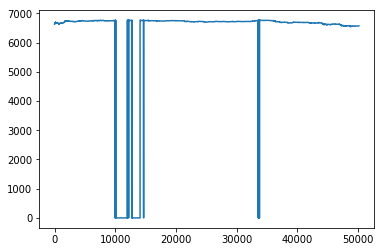

In [41]:
plt.plot(data2[:,-7])

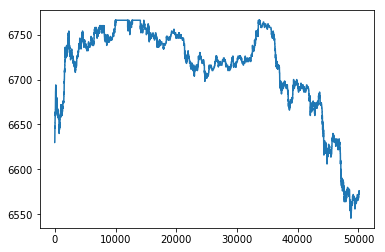

In [25]:
plt.plot(data.loc[:,'BidPrice1'])

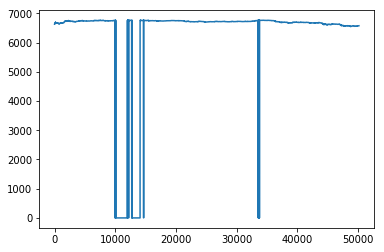

In [24]:
plt.plot(data.loc[:,'AskPrice1'])

In [23]:
data.columns

Index(['date', 'ReceiveTime', 'Symbol', 'Type', 'PreSettlePrice',
       'PreClosePrice', 'PreOpenInterest', 'OpenPrice', 'HighestPrice',
       'LowestPrice', 'LastPrice', 'BidPrice1', 'BidPrice2', 'BidPrice3',
       'BidPrice4', 'BidPrice5', 'AskPrice1', 'AskPrice2', 'AskPrice3',
       'AskPrice4', 'AskPrice5', 'BidVol1', 'BidVol2', 'BidVol3', 'BidVol4',
       'BidVol5', 'AskVol1', 'AskVol2', 'AskVol3', 'AskVol4', 'AskVol5',
       'Volume', 'Turnover', 'OpenInterest', 'ClosePrice', 'SettlePrice',
       'WAvgPrice', 'HistoricalHigh', 'HistoricalLow', 'UpperLimitPrice',
       'LowerLimitPrice', 'TotalBidVol', 'TotalAskVol', 'InternalDate', 'Time',
       'CalendarDate', 'Category', 'InternalTime', 'TradingDate',
       'BidWAvgPrice', 'AskWAvgPrice'],
      dtype='object')

In [30]:
len(data[data.loc[:,'AskPrice1']==0])

3495

In [37]:
len(data[data.loc[:,'BidPrice1']==0])!=0

False

In [39]:
rows=data.loc[:,'BidPrice1']==0

In [40]:
np.any(rows)

False

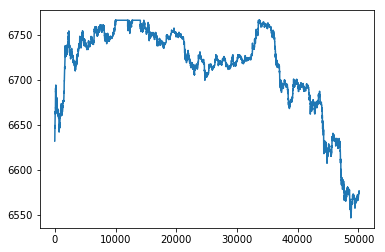

In [44]:
plt.plot(data2[:,-7])